In [1]:
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

2.19.0


In [2]:
df = pd.read_csv('Datasets/augmented_SRQ_data_v3.csv')
df = df.drop(columns='Unnamed: 0')
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df

,Date,Flight,Destination Airport,Airline,Boarded,Day_of_Week,Month,Day_of_Month,Destination Airport_encoded,Airline_encoded,day_sin,day_cos,month_sin,month_cos,dow_sin,dow_cos,route_mean,route_median,route_std
0,2023-09-14,AA2679,DFW,AA,130,3,9,14,23,0,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,96.518750,99.5,51.749150
1,2023-09-14,G41150,PIT,G4,155,3,9,14,60,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,148.430034,162.0,34.409989
2,2023-09-14,G4183,ABE,G4,152,3,9,14,0,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,150.730769,157.0,23.763546
3,2023-09-14,G4218,AVL,G4,144,3,9,14,6,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,126.549550,133.5,33.820457
4,2023-09-14,G42977,CAK,G4,143,3,9,14,14,5,0.299363,-0.954139,-8.660254e-01,-0.5,0.433884,-0.900969,152.762452,160.0,22.801929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12555,2025-07-20,WN4409,IND,WN,71,6,7,20,40,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,105.357143,111.0,35.060103
12556,2025-07-20,WN4605,MDW,WN,125,6,7,20,49,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,120.400000,122.0,39.266401
12557,2025-07-20,WN4606,STL,WN,75,6,7,20,71,9,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,119.448980,128.0,35.404741
12558,2025-07-20,XP306,HVN,XP,132,6,7,20,36,10,-0.790776,-0.612106,1.224647e-16,-1.0,-0.781831,0.623490,121.601604,129.0,37.176401


In [3]:
#STEP 1: Identify and fix the NaN feature problem

print("DEBUGGING FEATURE ISSUES")
print("="*50)

# Check original features before scaling
feature_columns = [
    'Destination Airport_encoded', 'Airline_encoded',
    'day_sin', 'month_sin', 'dow_sin',
    'day_cos', 'month_cos', 'dow_cos', 
    'route_mean', 'route_median', 'route_std',
]

X = df[feature_columns]
print(f"Original feature columns: {len(feature_columns)}")
print(f"Actual X shape: {X.shape}")

DEBUGGING FEATURE ISSUES
Original feature columns: 11
Actual X shape: (12560, 11)


In [4]:
# Check for problems in original data
print("\nOriginal feature statistics:")
for i, col in enumerate(feature_columns):
    col_data = X[col]
    print(f"{i}: {col}")
    print(f"   Range: {col_data.min():.6f} to {col_data.max():.6f}")
    print(f"   Mean: {col_data.mean():.6f}, Std: {col_data.std():.6f}")
    print(f"   Unique values: {col_data.nunique()}")
    print(f"   Has NaN: {col_data.isna().sum()}")
    
    # Check for zero variance
    if col_data.std() < 1e-10:
        print(f"   ⚠️  WARNING: Near-zero variance feature!")
    if col_data.isna().sum() > 0:
        print(f"   ⚠️  WARNING: Contains NaN values!")
    print()


Original feature statistics:
0: Destination Airport_encoded
   Range: 0.000000 to 75.000000
   Mean: 32.885111, Std: 20.783765
   Unique values: 76
   Has NaN: 0

1: Airline_encoded
   Range: 0.000000 to 10.000000
   Mean: 4.713455, Std: 2.731731
   Unique values: 11
   Has NaN: 0

2: day_sin
   Range: -0.998717 to 0.998717
   Mean: -0.013993, Std: 0.712611
   Unique values: 31
   Has NaN: 0

3: month_sin
   Range: -1.000000 to 1.000000
   Mean: 0.203420, Std: 0.680029
   Unique values: 11
   Has NaN: 0

4: dow_sin
   Range: -0.974928 to 0.974928
   Mean: -0.110091, Std: 0.681173
   Unique values: 7
   Has NaN: 0

5: day_cos
   Range: -0.994869 to 1.000000
   Mean: -0.021112, Std: 0.701159
   Unique values: 25
   Has NaN: 0

6: month_cos
   Range: -1.000000 to 1.000000
   Mean: 0.142378, Std: 0.689916
   Unique values: 11
   Has NaN: 0

7: dow_cos
   Range: -0.900969 to 1.000000
   Mean: -0.027474, Std: 0.723330
   Unique values: 7
   Has NaN: 0

8: route_mean
   Range: 10.000000 to 1

In [5]:
# STEP 2: Clean the data and remove problematic features

print("CLEANING DATA")
print("="*50)

# Remove features with zero variance or NaN values
def clean_features(df, feature_cols):
    clean_features = []
    X_clean = df[feature_cols].copy()
    
    for col in feature_cols:
        col_data = X_clean[col]
        
        # Check for NaN
        if col_data.isna().sum() > 0:
            print(f"Removing {col}: Contains {col_data.isna().sum()} NaN values")
            continue
            
        # Check for zero variance
        if col_data.std() < 1e-10:
            print(f"Removing {col}: Zero/near-zero variance (std={col_data.std():.2e})")
            continue
            
        # Check for infinite values
        if np.isinf(col_data).sum() > 0:
            print(f"Removing {col}: Contains infinite values")
            continue
            
        clean_features.append(col)
    
    return clean_features, X_clean[clean_features]

CLEANING DATA


In [6]:
# Clean features
clean_feature_names, X_clean = clean_features(df, feature_columns)
print(f"\nKept {len(clean_feature_names)} out of {len(feature_columns)} features")
print(f"Cleaned features: {clean_feature_names}")

Removing route_std: Contains 12 NaN values

Kept 10 out of 11 features
Cleaned features: ['Destination Airport_encoded', 'Airline_encoded', 'day_sin', 'month_sin', 'dow_sin', 'day_cos', 'month_cos', 'dow_cos', 'route_mean', 'route_median']


In [7]:
# Ensure data is sorted by date
df_sorted = df.sort_values('Date').reset_index(drop=True)
X_clean_sorted = X_clean.loc[df_sorted.index]
y_sorted = df_sorted['Boarded']
dates_sorted = df_sorted['Date']


In [8]:
# Chronological split
split_index = int(len(df_sorted) * 0.8)

X_train_clean = X_clean_sorted.iloc[:split_index]
X_test_clean = X_clean_sorted.iloc[split_index:]
y_train_clean = y_sorted.iloc[:split_index]
y_test_clean = y_sorted.iloc[split_index:]
dates_train_clean = dates_sorted.iloc[:split_index]
dates_test_clean = dates_sorted.iloc[split_index:]

print(f"\nCleaned data shapes:")
print(f"X_train: {X_train_clean.shape}")
print(f"X_test: {X_test_clean.shape}")



Cleaned data shapes:
X_train: (10048, 10)
X_test: (2512, 10)


In [9]:
# STEP 4: Apply scaling with clean data

scaler_clean = StandardScaler()
X_train_scaled_clean = scaler_clean.fit_transform(X_train_clean)
X_test_scaled_clean = scaler_clean.transform(X_test_clean)

# Verify no NaN values after scaling
print(f"\nAfter scaling - any NaN values: {np.isnan(X_train_scaled_clean).sum()}")
print(f"Feature means after scaling: {X_train_scaled_clean.mean(axis=0)}")
print(f"Feature stds after scaling: {X_train_scaled_clean.std(axis=0)}")



After scaling - any NaN values: 0
Feature means after scaling: [ 2.82859369e-18  5.65718739e-18  6.78862486e-17  0.00000000e+00
 -9.90007793e-18  1.41429685e-17  5.09146865e-17 -8.48578108e-18
  2.40430464e-16 -1.13143748e-17]
Feature stds after scaling: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [10]:
# STEP 5: Build and train model with clean data

# Validation split from training data
val_split_idx = int(len(X_train_clean) * 0.8)
X_train_final = X_train_scaled_clean[:val_split_idx]
X_val_final = X_train_scaled_clean[val_split_idx:]
y_train_final = y_train_clean.iloc[:val_split_idx]
y_val_final = y_train_clean.iloc[val_split_idx:]

# Try both with and without log transformation
print(f"\nTarget statistics:")
print(f"Original scale - Mean: {y_train_final.mean():.1f}, Std: {y_train_final.std():.1f}")
print(f"Original scale - Range: {y_train_final.min():.1f} to {y_train_final.max():.1f}")



Target statistics:
Original scale - Mean: 122.2, Std: 43.4
Original scale - Range: 10.0 to 249.0


In [11]:
y_train_log = np.log1p(y_train_final)
y_val_log = np.log1p(y_val_final)
print(f"Log scale - Mean: {y_train_log.mean():.3f}, Std: {y_train_log.std():.3f}")

Log scale - Mean: 4.720, Std: 0.497


In [12]:
# Model 1: Without log transformation
print(f"\n{'='*20} MODEL WITHOUT LOG TRANSFORM {'='*20}")

model_no_log = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(len(clean_feature_names),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1, activation='relu')  # ReLU for positive outputs
])

model_no_log.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mae',
    metrics=['mae', 'mse']
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-6,
        verbose=1
    )
]

# Train model
history_no_log = model_no_log.fit(
    X_train_final,
    y_train_final,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_final, y_val_final),
    callbacks=callbacks,
    verbose=1
)



==================== MODEL WITHOUT LOG TRANSFORM ====================
Epoch 1/200


C:\Users\KamarioSinclair\.conda\envs\pax-prediction\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 96.0189 - mae: 96.0189 - mse: 11871.9678 - val_loss: 48.3133 - val_mae: 48.3133 - val_mse: 3933.3420 - learning_rate: 0.0010
Epoch 2/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 48.8671 - mae: 48.8671 - mse: 4075.1069 - val_loss: 37.0130 - val_mae: 37.0130 - val_mse: 2471.8608 - learning_rate: 0.0010
Epoch 3/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 38.7371 - mae: 38.7371 - mse: 2439.8594 - val_loss: 35.5055 - val_mae: 35.5055 - val_mse: 2265.0269 - learning_rate: 0.0010
Epoch 4/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 35.9121 - mae: 35.9121 - mse: 2069.5642 - val_loss: 33.4729 - val_mae: 33.4729 - val_mse: 1929.1940 - learning_rate: 0.0010
Epoch 5/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 35.2534 - mae: 35.2534 - mse: 1980.1222 - val_loss: 32.8178 - val_mae: 32.8178 - val_mse: 1796.0885 - learning_rate: 0.0010
Epoch 6/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 34.7934 - mae: 34.7934 - 

In [13]:
# Model 2: With log transformation
print(f"\n{'='*20} MODEL WITH LOG TRANSFORM {'='*20}")

model_log = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(len(clean_feature_names),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    
    tf.keras.layers.Dense(1)  # No activation for log space
])

model_log.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

history_log = model_log.fit(
    X_train_final,
    y_train_log,
    epochs=200,
    batch_size=32,
    validation_data=(X_val_final, y_val_log),
    callbacks=callbacks,
    verbose=1
)


==================== MODEL WITH LOG TRANSFORM ====================
Epoch 1/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 2.8436 - mae: 1.2918 - mse: 2.8436 - val_loss: 0.4861 - val_mae: 0.5962 - val_mse: 0.4861 - learning_rate: 0.0010
Epoch 2/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.0666 - mae: 0.8115 - mse: 1.0666 - val_loss: 0.2794 - val_mae: 0.3894 - val_mse: 0.2794 - learning_rate: 0.0010
Epoch 3/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9082 - mae: 0.7459 - mse: 0.9082 - val_loss: 0.2586 - val_mae: 0.3684 - val_mse: 0.2586 - learning_rate: 0.0010
Epoch 4/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8081 - mae: 0.7048 - mse: 0.8081 - val_loss: 0.2404 - val_mae: 0.3774 - val_mse: 0.2404 - learning_rate: 0.0010
Epoch 5/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7019 - mae: 0.6548 - mse: 0.7019 - val_loss: 0.2335 - val_mae: 0.3636 - val_mse: 0.2335 - learning_rate: 0.0010
Epoch 6/200
252/252 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

In [14]:
# STEP 6: Evaluate both models

print(f"\n{'='*20} MODEL EVALUATION {'='*20}")

# Predictions
y_pred_no_log = model_no_log.predict(X_test_scaled_clean).flatten()
y_pred_no_log = np.maximum(0, y_pred_no_log)  # Ensure non-negative

y_pred_log_raw = model_log.predict(X_test_scaled_clean).flatten()
y_pred_log = np.expm1(y_pred_log_raw)

y_true = y_test_clean.values


==================== MODEL EVALUATION ====================
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step   
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step   


In [15]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print("Model without log transform:")
mae1 = mean_absolute_error(y_true, y_pred_no_log)
r2_1 = r2_score(y_true, y_pred_no_log)
print(f"MAE: {mae1:.2f}, R²: {r2_1:.4f}")
print(f"Pred range: {y_pred_no_log.min():.1f} - {y_pred_no_log.max():.1f}")

print("\nModel with log transform:")
mae2 = mean_absolute_error(y_true, y_pred_log)
r2_2 = r2_score(y_true, y_pred_log)
print(f"MAE: {mae2:.2f}, R²: {r2_2:.4f}")
print(f"Pred range: {y_pred_log.min():.1f} - {y_pred_log.max():.1f}")


Model without log transform:
MAE: 31.30, R²: -0.1312
Pred range: 86.8 - 162.4

Model with log transform:
MAE: 31.02, R²: -0.0377
Pred range: 95.2 - 229.9


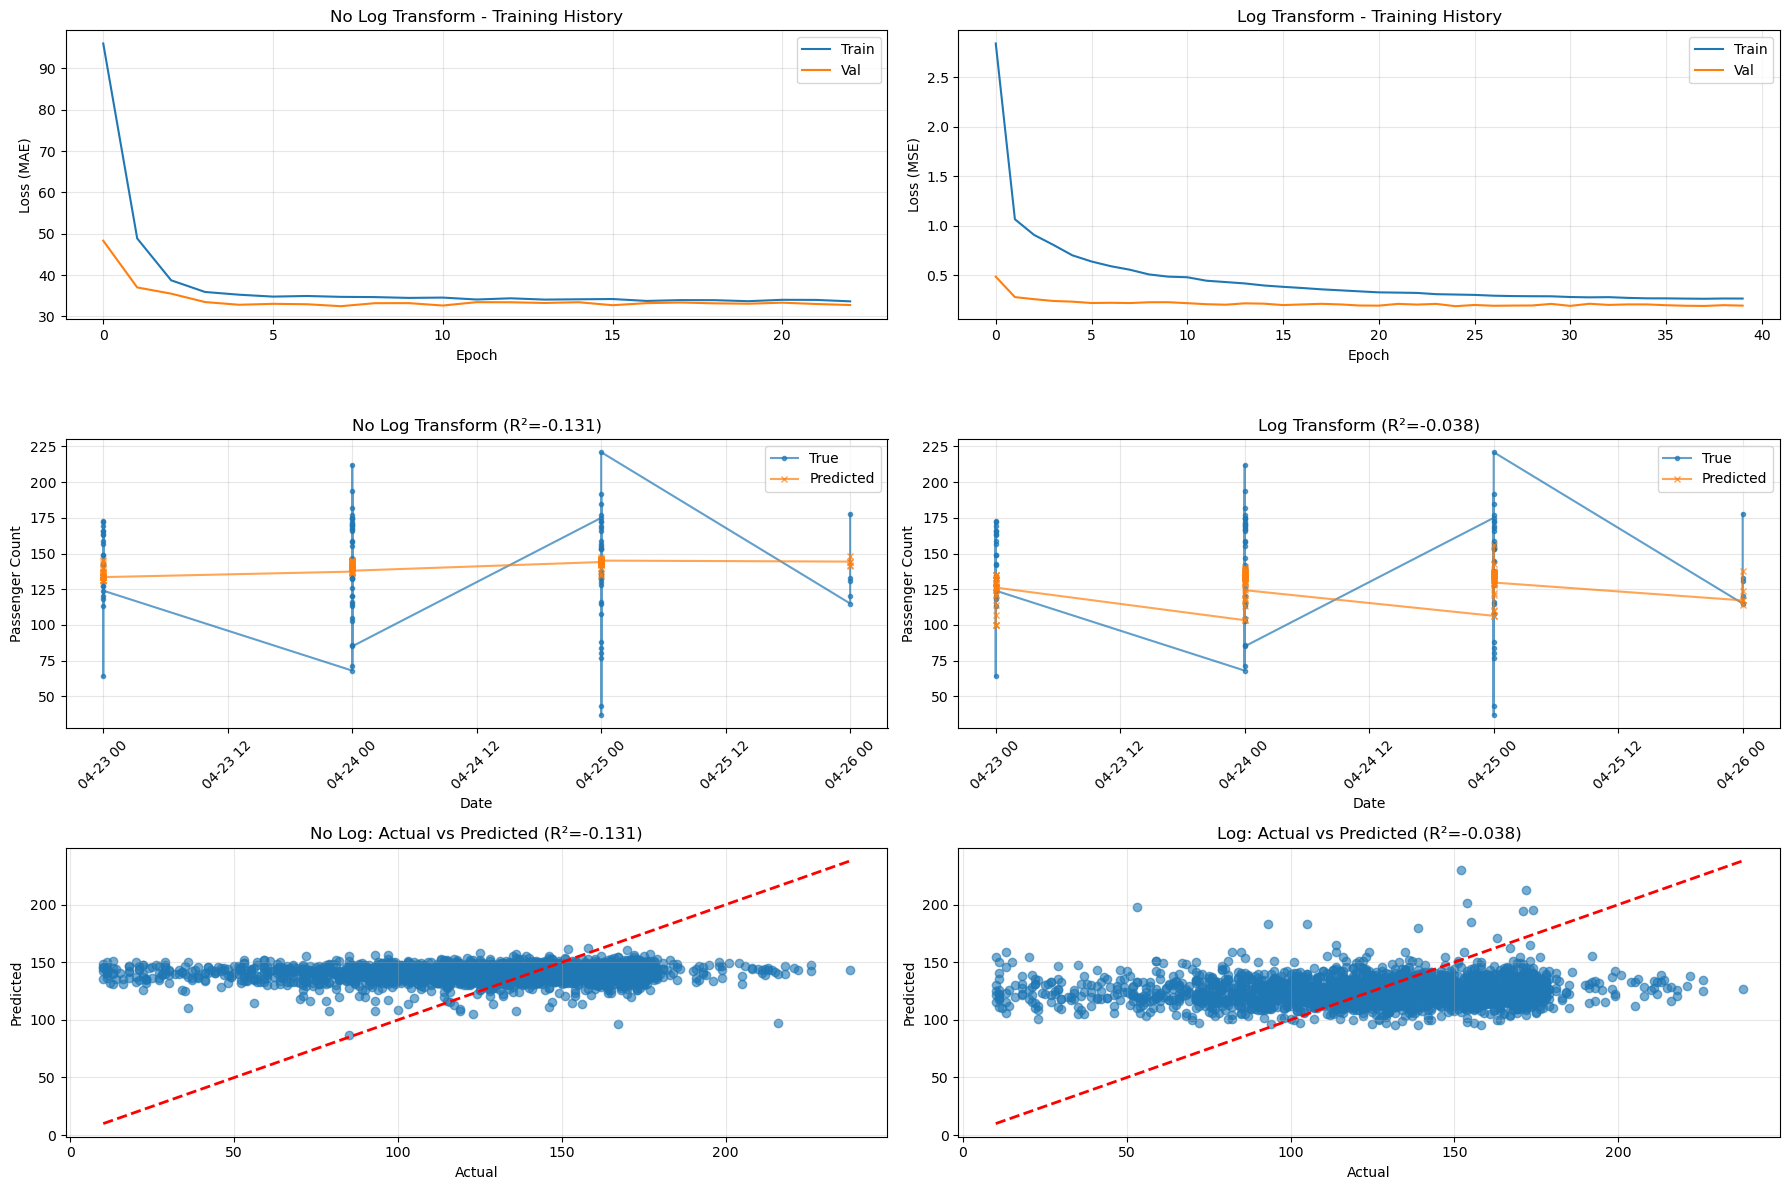


SUMMARY:
Removed problematic features, now using 10 features
Both models should now train properly without NaN issues
Compare R² scores to see which approach works better for your data


In [16]:
plt.figure(figsize=(18, 12))

# Training histories
plt.subplot(3, 2, 1)
plt.plot(history_no_log.history['loss'], label='Train')
plt.plot(history_no_log.history['val_loss'], label='Val')
plt.title('No Log Transform - Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.plot(history_log.history['loss'], label='Train')
plt.plot(history_log.history['val_loss'], label='Val')
plt.title('Log Transform - Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)

# Time series plots
n_plot = min(100, len(y_test_clean))
dates_plot = dates_test_clean.iloc[:n_plot].reset_index(drop=True)

plt.subplot(3, 2, 3)
plt.plot(dates_plot, y_true[:n_plot], 'o-', label='True', markersize=3, alpha=0.7)
plt.plot(dates_plot, y_pred_no_log[:n_plot], 'x-', label='Predicted', markersize=4, alpha=0.7)
plt.title(f'No Log Transform (R²={r2_1:.3f})')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.subplot(3, 2, 4)
plt.plot(dates_plot, y_true[:n_plot], 'o-', label='True', markersize=3, alpha=0.7)
plt.plot(dates_plot, y_pred_log[:n_plot], 'x-', label='Predicted', markersize=4, alpha=0.7)
plt.title(f'Log Transform (R²={r2_2:.3f})')
plt.xlabel('Date')
plt.ylabel('Passenger Count')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Scatter plots
plt.subplot(3, 2, 5)
plt.scatter(y_true, y_pred_no_log, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'No Log: Actual vs Predicted (R²={r2_1:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 6)
plt.scatter(y_true, y_pred_log, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Log: Actual vs Predicted (R²={r2_2:.3f})')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSUMMARY:")
print(f"Removed problematic features, now using {len(clean_feature_names)} features")
print(f"Both models should now train properly without NaN issues")
print(f"Compare R² scores to see which approach works better for your data")

ADVANCED FEATURE ANALYSIS
Destination Airport_encoded:   0.0461
Airline_encoded          :   0.1461
day_sin                  :  -0.0270
month_sin                :   0.1823
dow_sin                  :  -0.0723
day_cos                  :   0.0182
month_cos                :  -0.1290
dow_cos                  :   0.0869
route_mean               :   0.6035
route_median             :   0.5981

Features ranked by correlation with target:
route_mean               :   0.6035
route_median             :   0.5981
month_sin                :   0.1823
Airline_encoded          :   0.1461
month_cos                :  -0.1290
dow_cos                  :   0.0869
dow_sin                  :  -0.0723
Destination Airport_encoded:   0.0461
day_sin                  :  -0.0270
day_cos                  :   0.0182

High feature correlations (>0.8):
route_mean <-> route_median: 0.991


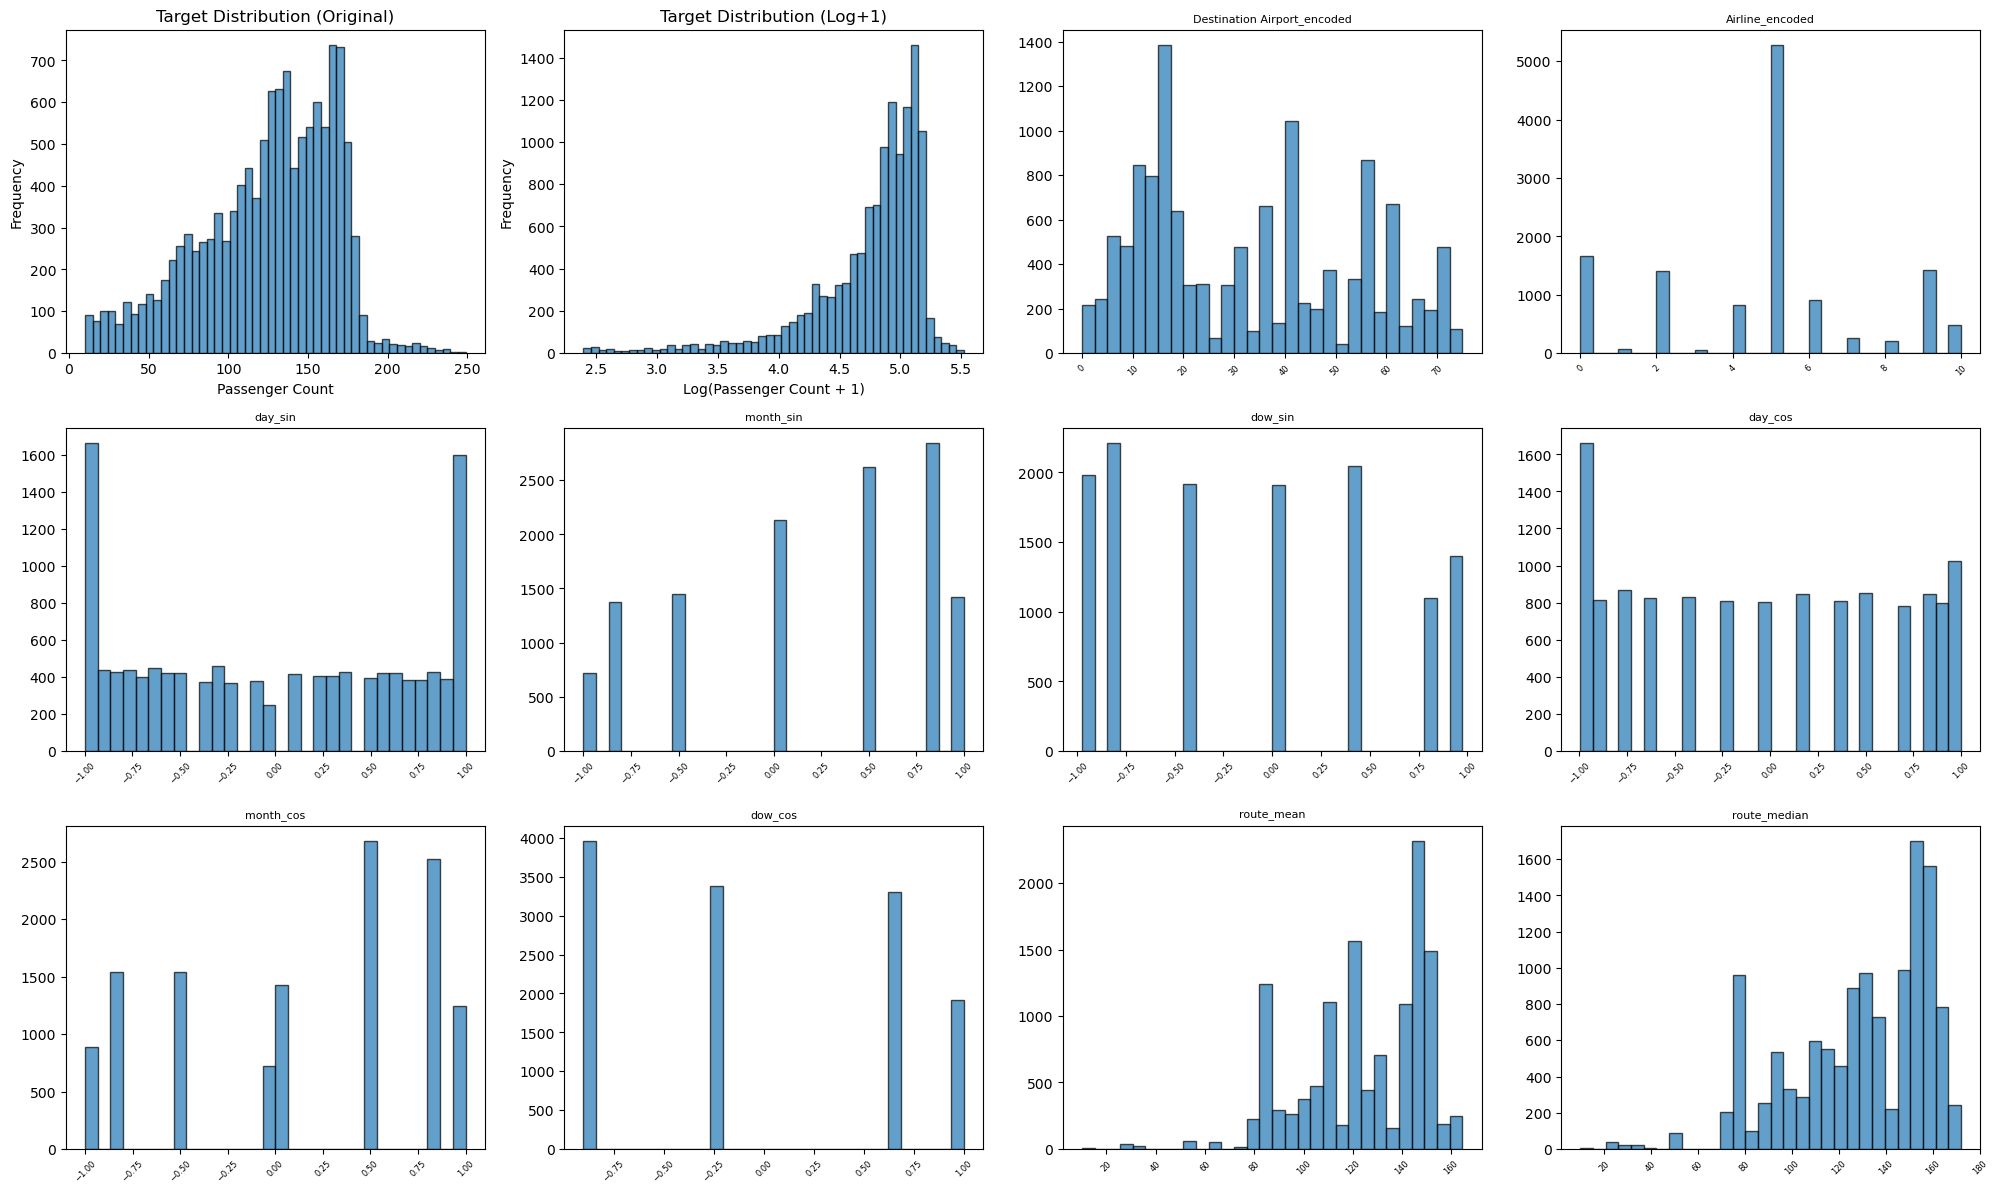


==================== TESTING DIFFERENT ARCHITECTURES ====================

--- Testing Simple Model ---


C:\Users\KamarioSinclair\.conda\envs\pax-prediction\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


MAE: 35.43, R²: -0.4783
Prediction range: 125.3 - 178.3 (span: 53.1)

--- Testing Linear Model ---
MAE: 72.50, R²: -3.9625
Prediction range: 0.0 - 206.4 (span: 206.4)

--- Testing Deep_Swish Model ---
MAE: 32.35, R²: -0.2338
Prediction range: 121.3 - 161.8 (span: 40.5)

==================== PERMUTATION FEATURE IMPORTANCE ====================
Feature importance (using Deep_Swish model):
dow_sin                  :   0.4354
Airline_encoded          :   0.2822
dow_cos                  :   0.0799
month_sin                :   0.0560
Destination Airport_encoded:   0.0226
day_cos                  :   0.0042
month_cos                :  -0.0274
route_median             :  -0.0274
day_sin                  :  -0.0327
route_mean               :  -0.1502

==================== FEATURE SELECTION EXPERIMENT ====================
Training with top features: ['dow_sin', 'Airline_encoded', 'dow_cos', 'month_sin', 'Destination Airport_encoded', 'day_cos']


C:\Users\KamarioSinclair\.conda\envs\pax-prediction\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Selected features model:
MAE: 32.33, R²: -0.2089
Prediction range: 110.0 - 176.8


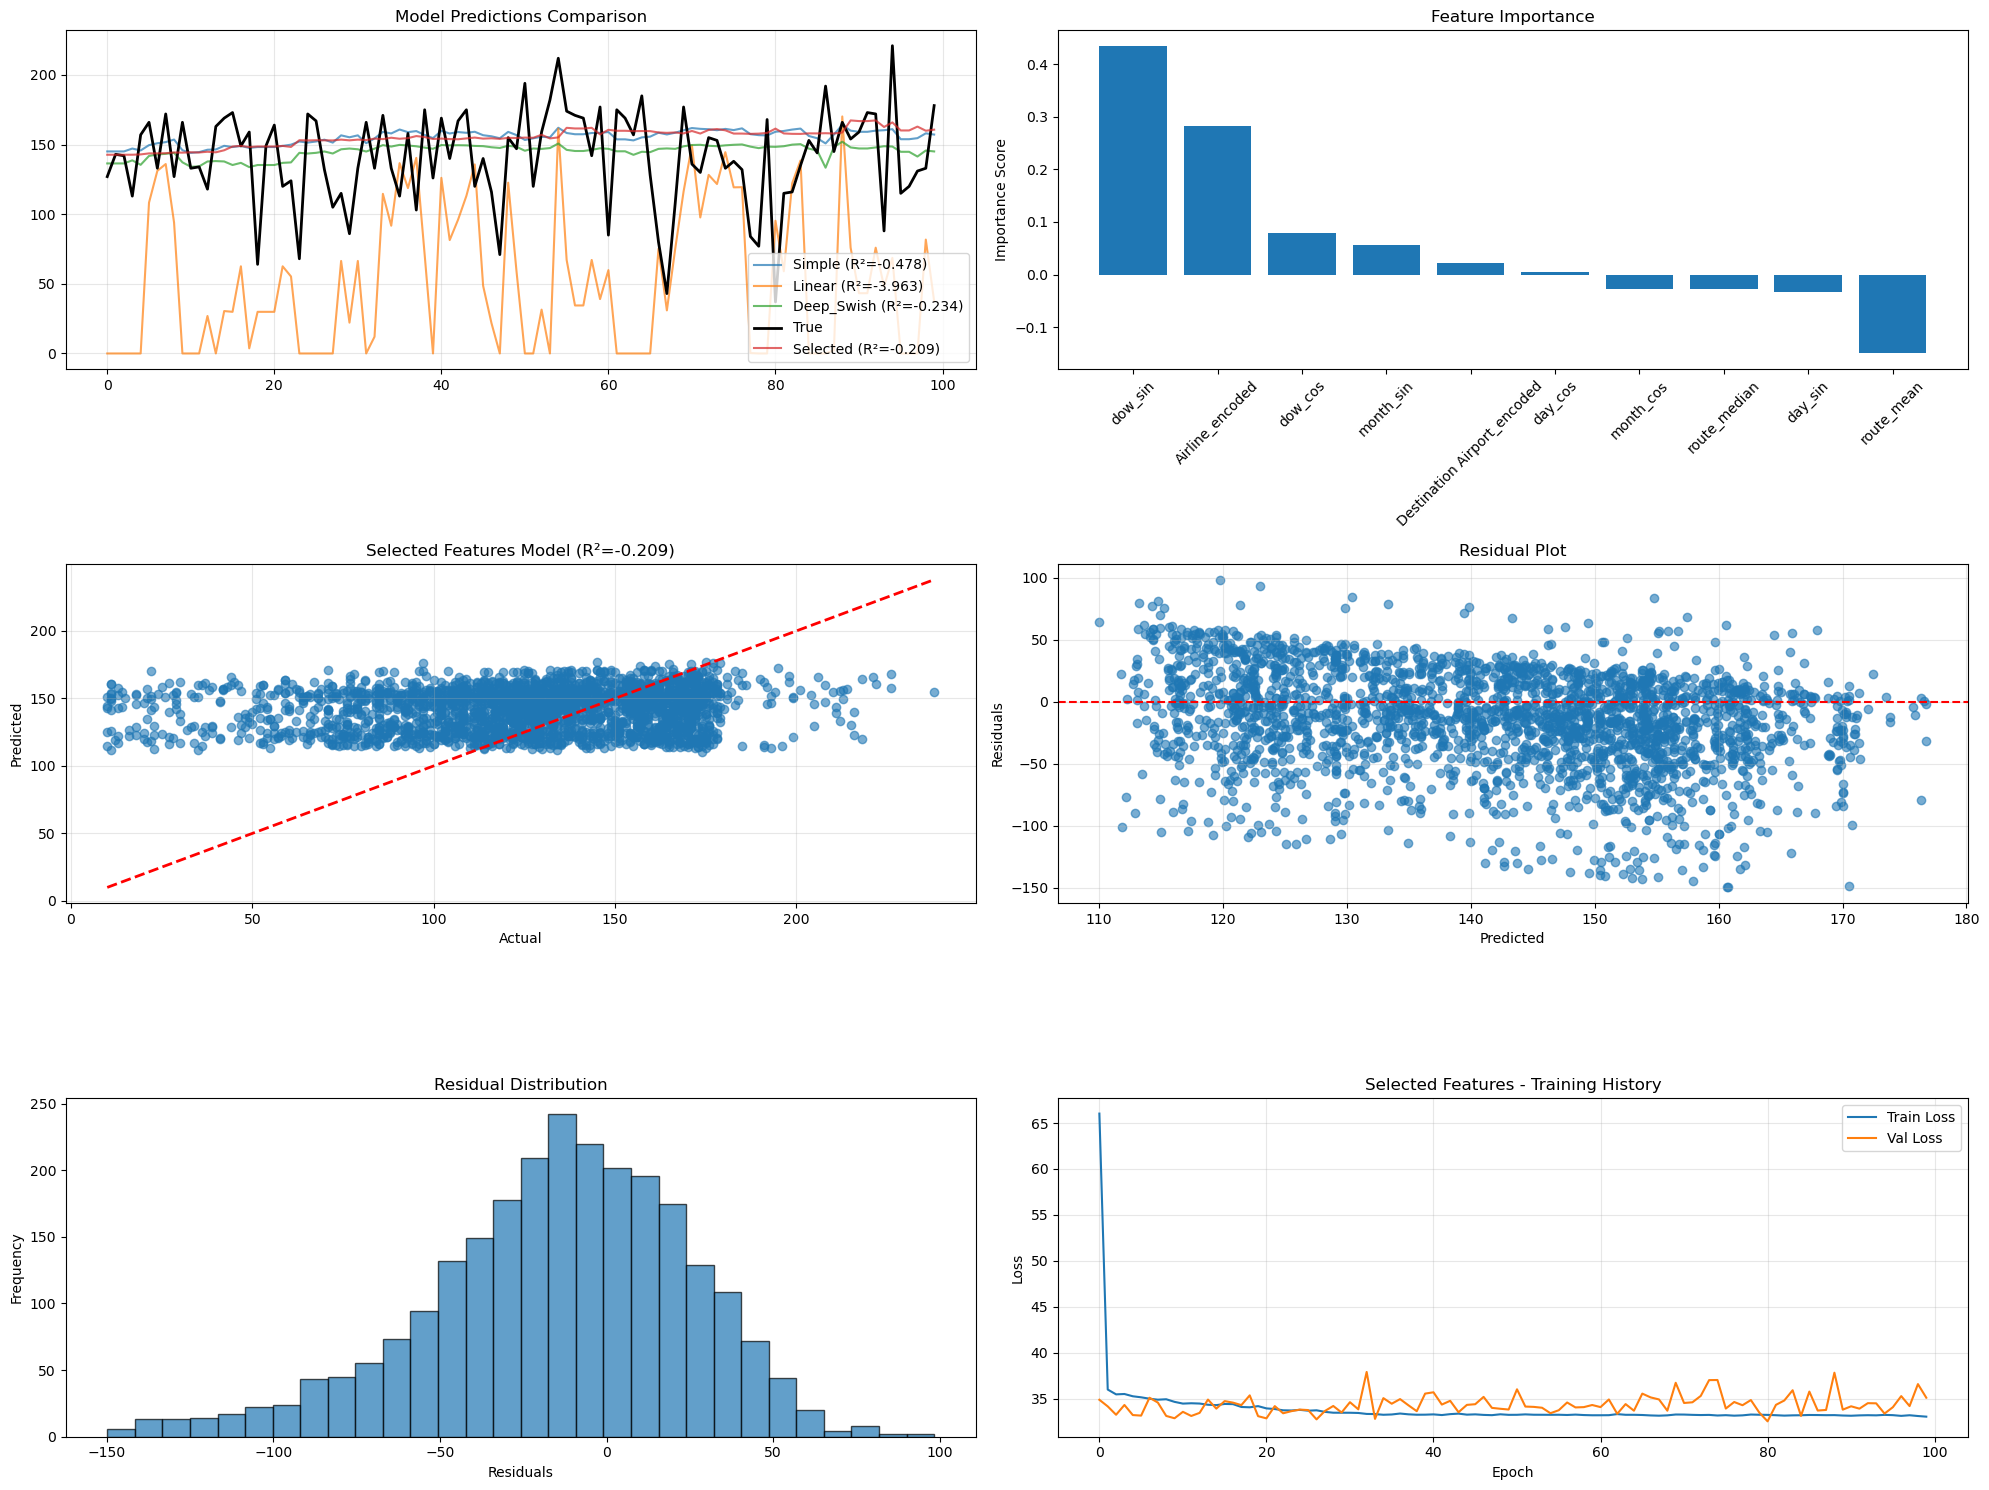


DIAGNOSIS SUMMARY:
1. Feature correlations: Check which features actually correlate with target
2. Best architecture: Deep_Swish with R² = -0.2338
3. Feature selection: R² improved from -0.2338 to -0.2089
4. Most important features: dow_sin, Airline_encoded, dow_cos

⚠️  WARNING: Even with feature selection, R² < 0.3 suggests:
   - Features may not be predictive of passenger counts
   - Need better feature engineering
   - Consider external factors (weather, holidays, events)
   - Data quality issues (wrong target variable?)


In [20]:
# ADVANCED DIAGNOSTICS - Find why model isn't learning patterns

print("ADVANCED FEATURE ANALYSIS")
print("="*60)

# 1. Analyze feature correlations with target
correlations = []
for feature in clean_feature_names:
    corr = df[feature].corr(df['Boarded'])
    correlations.append((feature, corr))
    print(f"{feature:25s}: {corr:8.4f}")

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
print(f"\nFeatures ranked by correlation with target:")
for feature, corr in correlations:
    print(f"{feature:25s}: {corr:8.4f}")

# 2. Check for feature multicollinearity
import pandas as pd
correlation_matrix = df[clean_feature_names].corr()
print(f"\nHigh feature correlations (>0.8):")
for i in range(len(clean_feature_names)):
    for j in range(i+1, len(clean_feature_names)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.8:
            print(f"{clean_feature_names[i]} <-> {clean_feature_names[j]}: {corr_val:.3f}")

# 3. Analyze target distribution and potential issues
plt.figure(figsize=(20, 12))

plt.subplot(3, 4, 1)
plt.hist(df['Boarded'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Target Distribution (Original)')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

plt.subplot(3, 4, 2)
plt.hist(np.log1p(df['Boarded']), bins=50, alpha=0.7, edgecolor='black')
plt.title('Target Distribution (Log+1)')
plt.xlabel('Log(Passenger Count + 1)')
plt.ylabel('Frequency')

# 4. Feature distributions
for i, feature in enumerate(clean_feature_names[:10]):  # First 10 features
    plt.subplot(3, 4, i+3)
    plt.hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
    plt.title(f'{feature}', fontsize=8)
    plt.xticks(rotation=45, fontsize=6)

plt.tight_layout()
plt.show()

# 5. Try different model architectures
print(f"\n{'='*20} TESTING DIFFERENT ARCHITECTURES {'='*20}")

# Architecture 1: Simpler model
model_simple = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(len(clean_feature_names),)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

# Architecture 2: Linear model (for comparison)
model_linear = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=(len(clean_feature_names),), activation='relu')
])

# Architecture 3: Deeper with different activations
model_deep = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64, activation='swish', input_shape=(len(clean_feature_names),)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(32, activation='swish'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='swish'),
    tf.keras.layers.Dense(1, activation='relu')
])

models_to_test = [
    ("Simple", model_simple),
    ("Linear", model_linear), 
    ("Deep_Swish", model_deep)
]

results = {}

for name, model in models_to_test:
    print(f"\n--- Testing {name} Model ---")
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),  # Higher LR
        loss='mae',
        metrics=['mae']
    )
    
    # Quick training
    history = model.fit(
        X_train_final, y_train_final,
        epochs=50,
        batch_size=64,
        validation_data=(X_val_final, y_val_final),
        verbose=0
    )
    
    # Predictions
    pred = model.predict(X_test_scaled_clean, verbose=0).flatten()
    pred = np.maximum(0, pred)
    
    # Metrics
    mae = mean_absolute_error(y_true, pred)
    r2 = r2_score(y_true, pred)
    pred_range = pred.max() - pred.min()
    
    results[name] = {
        'MAE': mae,
        'R2': r2,
        'pred_range': pred_range,
        'predictions': pred
    }
    
    print(f"MAE: {mae:.2f}, R²: {r2:.4f}")
    print(f"Prediction range: {pred.min():.1f} - {pred.max():.1f} (span: {pred_range:.1f})")

# 6. Feature importance using permutation
print(f"\n{'='*20} PERMUTATION FEATURE IMPORTANCE {'='*20}")

def permutation_importance(model, X_test, y_test, feature_names):
    # Baseline score
    baseline_pred = model.predict(X_test, verbose=0).flatten()
    baseline_pred = np.maximum(0, baseline_pred)
    baseline_mae = mean_absolute_error(y_test, baseline_pred)
    
    importances = []
    
    for i, feature_name in enumerate(feature_names):
        # Create copy and shuffle one feature
        X_permuted = X_test.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
        
        # Get score with shuffled feature
        permuted_pred = model.predict(X_permuted, verbose=0).flatten()
        permuted_pred = np.maximum(0, permuted_pred)
        permuted_mae = mean_absolute_error(y_test, permuted_pred)
        
        # Importance = increase in error
        importance = permuted_mae - baseline_mae
        importances.append((feature_name, importance))
    
    return sorted(importances, key=lambda x: x[1], reverse=True)

# Use the best performing model for feature importance
best_model_name = max(results.keys(), key=lambda k: results[k]['R2'])
best_model = dict(models_to_test)[best_model_name]

importances = permutation_importance(
    best_model, X_test_scaled_clean, y_true, clean_feature_names
)

print(f"Feature importance (using {best_model_name} model):")
for feature, importance in importances:
    print(f"{feature:25s}: {importance:8.4f}")

# 7. Try feature selection based on importance
print(f"\n{'='*20} FEATURE SELECTION EXPERIMENT {'='*20}")

# Keep only top features
top_features = [name for name, _ in importances[:6]]  # Top 6 features
print(f"Training with top features: {top_features}")

# Get indices of top features
top_indices = [clean_feature_names.index(feat) for feat in top_features]

X_train_top = X_train_final[:, top_indices]
X_val_top   = X_val_final[:,   top_indices]
X_test_top  = X_test_scaled_clean[:, top_indices]


# Train model with selected features
model_selected = tf.keras.models.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(len(top_features),)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='relu')
])

model_selected.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='mae',
    metrics=['mae']
)

history_selected = model_selected.fit(
    X_train_top, y_train_final,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_top, y_val_final),
    verbose=0
)

pred_selected = model_selected.predict(X_test_top, verbose=0).flatten()
pred_selected = np.maximum(0, pred_selected)

mae_selected = mean_absolute_error(y_true, pred_selected)
r2_selected = r2_score(y_true, pred_selected)

print(f"Selected features model:")
print(f"MAE: {mae_selected:.2f}, R²: {r2_selected:.4f}")
print(f"Prediction range: {pred_selected.min():.1f} - {pred_selected.max():.1f}")

# 8. Plot comparison of all approaches
plt.figure(figsize=(20, 15))

n_plot = min(100, len(y_true))
x_axis = range(n_plot)

plt.subplot(3, 2, 1)
for name, result in results.items():
    plt.plot(x_axis, result['predictions'][:n_plot], 
             label=f"{name} (R²={result['R2']:.3f})", alpha=0.7)
plt.plot(x_axis, y_true[:n_plot], 'k-', label='True', linewidth=2)
plt.plot(x_axis, pred_selected[:n_plot], 
         label=f"Selected (R²={r2_selected:.3f})", alpha=0.7)
plt.title('Model Predictions Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 2)
plt.bar(range(len(importances)), [imp[1] for imp in importances])
plt.xticks(range(len(importances)), [imp[0] for imp in importances], rotation=45)
plt.title('Feature Importance')
plt.ylabel('Importance Score')

plt.subplot(3, 2, 3)
plt.scatter(y_true, pred_selected, alpha=0.6)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Selected Features Model (R²={r2_selected:.3f})')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 4)
residuals = y_true - pred_selected
plt.scatter(pred_selected, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(3, 2, 5)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.title('Residual Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(3, 2, 6)
plt.plot(history_selected.history['loss'], label='Train Loss')
plt.plot(history_selected.history['val_loss'], label='Val Loss')
plt.title('Selected Features - Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("DIAGNOSIS SUMMARY:")
print(f"{'='*60}")
print(f"1. Feature correlations: Check which features actually correlate with target")
print(f"2. Best architecture: {best_model_name} with R² = {results[best_model_name]['R2']:.4f}")
print(f"3. Feature selection: R² improved from {results[best_model_name]['R2']:.4f} to {r2_selected:.4f}")
print(f"4. Most important features: {', '.join(top_features[:3])}")

if r2_selected < 0.3:
    print(f"\n⚠️  WARNING: Even with feature selection, R² < 0.3 suggests:")
    print(f"   - Features may not be predictive of passenger counts")
    print(f"   - Need better feature engineering")
    print(f"   - Consider external factors (weather, holidays, events)")
    print(f"   - Data quality issues (wrong target variable?)")

In [19]:
print("y_true:", y_true, "   type:", type(y_true))
print("pred_selected:", pred_selected[:5], " type:", type(pred_selected))

y_true: [127 143 142 ... 153 107 113]    type: <class 'numpy.ndarray'>
pred_selected: [139.03754 139.03754 139.03754 138.97495 139.27757]  type: <class 'numpy.ndarray'>
